In [16]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np

from configs import Hyperion, Hyperion_launch_conditions, current_airbrakes_model
from rocketpy import Environment, Flight, Rocket, GenericMotor

## RocketPy Simulation


### Environment


Define the `Environment` object


In [17]:
# Environment conditions
env = Environment(
    latitude=32.99028,
    longitude=-106.96972,
    date=(2023, 6, 23, 15),
    elevation=1401
)
# may want to add wind, make environment more detailed: https://github.com/RocketPy-Team/RocketPy/blob/master/docs/notebooks/environment/environment_class_usage.ipynb

Visualize the `Environment` object



Gravity Details

Acceleration of gravity at surface level:    9.7913 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5534 m/s²


Launch Site Details

Launch Date: 2023-06-23 15:00:00 UTC
Launch Site Latitude: 32.99028°
Launch Site Longitude: -106.96972°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315961.92 W    3651932.28 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1401.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 855.92 hPa
Surface Temperature: 279.06 K
Surface Air Density: 1.068 kg/m³
Surface Speed of Sound: 334.54 m/s


Earth Model Details

Earth Radius at Launch site: 6371.83 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



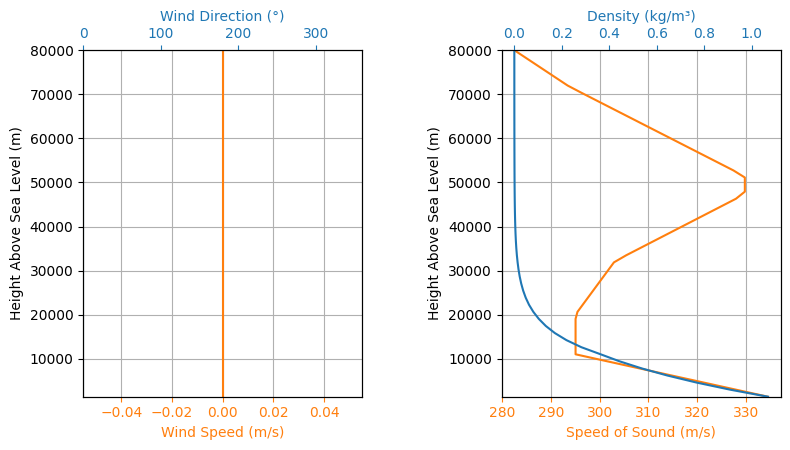

In [18]:
env.info()

### Motor


Define the `SolidMotor` object


In [19]:
thrust_dict = Hyperion.motor.thrust_curve
def thrust_curve(t):
    time_list = list(thrust_dict.keys())
    thrust_list = list(thrust_dict.values())
    if t < time_list[0]:
        return thrust_list[0]
    elif t > time_list[-1]:
        return 0
    else:
        return np.interp(t, time_list, thrust_list)

# rocket: nose_to_tail

motor_M2505 = GenericMotor(
    # burn specs:
    thrust_source=thrust_curve,
    burn_time=Hyperion.motor.burn_time,
    propellant_initial_mass=Hyperion.motor.fuel_mass_curve[0],
    dry_mass=Hyperion.motor.dry_mass,

    # geometry specs: Pro98 3G Gen2 casing 
    coordinate_system_orientation="nozzle_to_combustion_chamber",
    chamber_radius=0.064,
    chamber_height=0.548,
    chamber_position=0.274,
    nozzle_radius=0.027,
)

Motor Details
Total Burning Time: 3 s
Total Propellant Mass: 3.423 kg
Average Propellant Exhaust Velocity: 2156.601 m/s
Average Thrust: 2460.682 N
Maximum Thrust: 2934.0 N at 1.2244897959183674 s after ignition.
Total Impulse: 7382.046 Ns



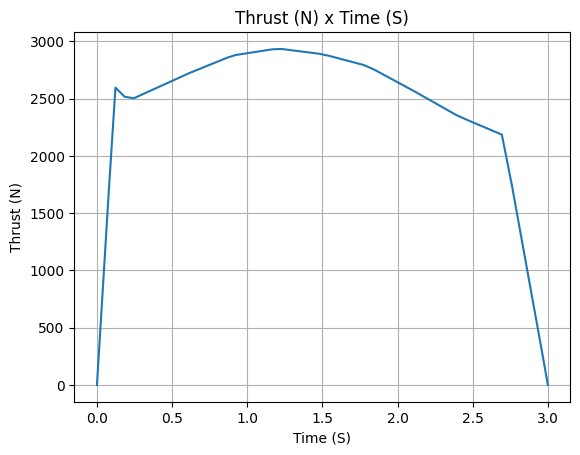

In [20]:
motor_M2505.info()

### Rocket


Create the `Rocket` object


In [21]:
Hyperion_RP = Rocket(
    radius = 0.06985, # 5.5" diameter circle
    mass = Hyperion.rocket_mass,
    inertia=(#TBU
        4.87,#TBU
        4.87,#TBU
        0.05,#TBU
    ),
    power_off_drag=Hyperion.Cd_rocket_at_Ma,#TBU
    power_on_drag=Hyperion.Cd_rocket_at_Ma,#TBU
    center_of_mass_without_motor=1.3,#TBU
    coordinate_system_orientation="tail_to_nose",
)

Hyperion_RP.set_rail_buttons(0.69, 0.21, 60)#TBU

Hyperion_RP.add_motor(motor=motor_M2505, position=0)

Adding aerodynamic surfaces


In [22]:
nose_cone = Hyperion_RP.add_nose(
    length=0.731,
    kind="Von Karman",
    position=2.073
)

fin_set = Hyperion_RP.add_trapezoidal_fins(
    3,
    span=0.135,
    root_chord=0.331,
    tip_chord=0.1395,
    position=0.314,#TBU
    sweep_length=0.0698, #TBU
)

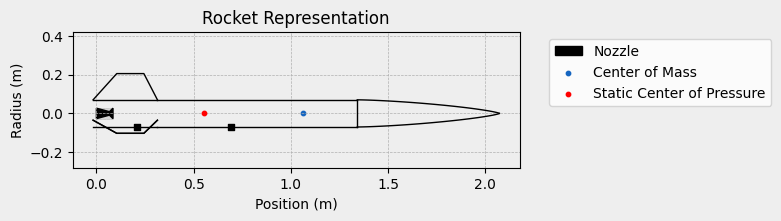

In [23]:
Hyperion_RP.draw()

In [24]:
Hyperion_RP.info()


Inertia Details

Rocket Mass: 19.137 kg (without motor)
Rocket Dry Mass: 21.447 kg (with unloaded motor)
Rocket Loaded Mass: 24.870 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 7.040 kg*m2
Rocket Inertia (with unloaded motor) 22: 7.040 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.050 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.06985 m
Rocket Frontal Area: 0.015328 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.111 m
Rocket Center of Dry Mass - Nozzle Exit: 1.189 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.915 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.126 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.963/rad

Center of Pressure

Nose Cone Center o

### Flight - no airbrakes


In [25]:
# Flight - no airbrakes
flight = Flight(
    rocket=Hyperion_RP,
    environment = env,
    rail_length = Hyperion_launch_conditions.L_launch_rail,
    inclination = Hyperion_launch_conditions.launch_rail_elevation,
    terminate_on_apogee=True,
)

Apogee: 4588.62 m ASL, 3187.62 m AGL
Apogee: 15055.26 ft ASL, 10458.58 ft AGL

Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 1401.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.707 | e1: -0.025 | e2: 0.025 | e3: -0.707
Euler Angles - Spin φ : 0.00° | Nutation θ: -4.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 3.652 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.18 m
Launch Rail Inclination: 86.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.375 s
Rail Departure Velocity: 28.816 m/s
Rail Departure Stability Margin: 3.739 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 10.740
Rail Departure Reynolds Number: 2.467e+05


Burn out State

Burn out time: 3.000 s
Altitude at burn out: 1841.62

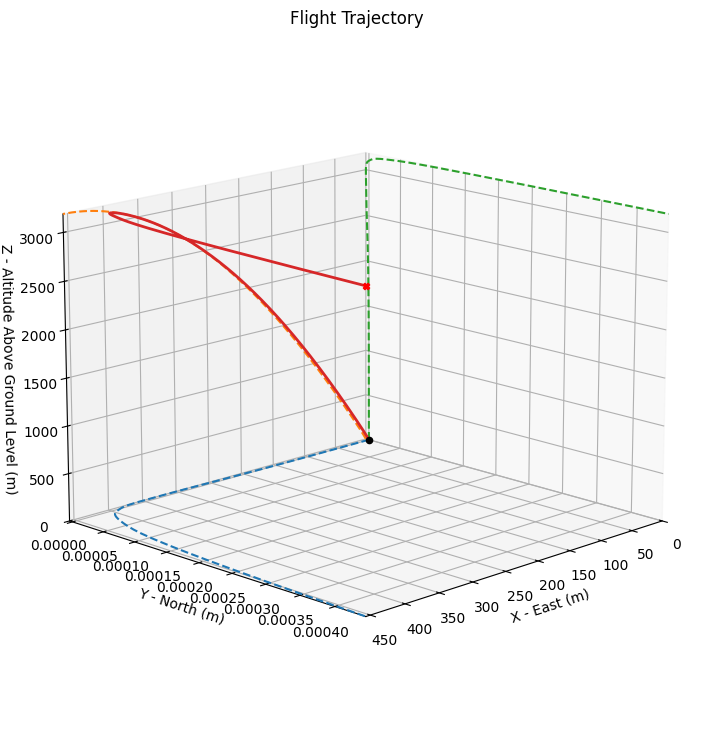

In [26]:
print(f"Apogee: {round(flight.apogee,2)} m ASL, {round(flight.apogee - env.elevation,2)} m AGL")
print(f"Apogee: {round(flight.apogee*3.281,2)} ft ASL, {round((flight.apogee - env.elevation)*3.281,2)} ft AGL")
flight.info()
flight.plots.trajectory_3d()

### Flight - with airbrakes

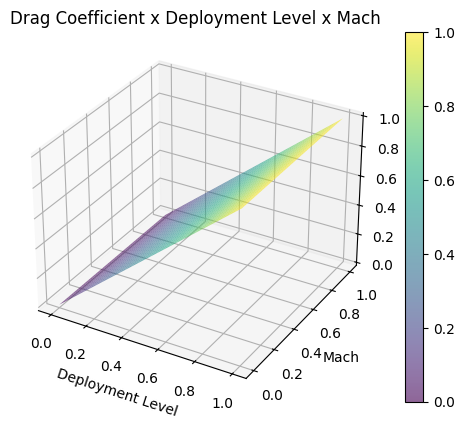

In [27]:
# Define airbrakes
# https://github.com/RocketPy-Team/RocketPy/blob/43b486ab266dca62449e2ad3abe9d427212bc92b/docs/user/airbrakes.rst
portion_deployed_per_sec = current_airbrakes_model.max_deployment_rate/current_airbrakes_model.max_deployment_angle
def controller_function(time, sampling_rate, state, state_history, observed_variables, air_brakes):
    if time < motor_M2505.burn_time[1]:
        return 0
    else:
        old_level = air_brakes.deployment_level
        if old_level == 0: print(f'Beginning airbrake deployment at t={time}')
        new_level = min(old_level + portion_deployed_per_sec/sampling_rate, 1)
        if old_level != new_level:
            if new_level == 1:
                print(f'Airbrakes fully deployed at t={time}')
        # print(old_level, new_level)
        air_brakes.deployment_level = new_level
        return new_level
    # eventually actually implemet a controller, for now just make it go to max deployment to determine stopping power
    # height = state[2]
    # v_y = state[5]


def drag_coefficient_curve(deployment_level, free_stream_mach):
    return current_airbrakes_model.Cd_brakes*deployment_level

airbrakes = Hyperion_RP.add_air_brakes(
    drag_coefficient_curve=drag_coefficient_curve,
    controller_function=controller_function,
    sampling_rate=100,
    clamp=True,
    reference_area=current_airbrakes_model.A_flap*current_airbrakes_model.num_flaps*np.sin(np.deg2rad(current_airbrakes_model.max_deployment_angle)),
    initial_observed_variables=0,
    override_rocket_drag=False
)
airbrakes.all_info()

In [28]:
flight_airbrakes = Flight(
    rocket=Hyperion_RP,
    environment = env,
    rail_length = Hyperion_launch_conditions.L_launch_rail,
    inclination = Hyperion_launch_conditions.launch_rail_elevation,
    time_overshoot=False,
    terminate_on_apogee=True
)

Beginning airbrake deployment at t=3.0
Airbrakes fully deployed at t=11.18


In [29]:
print(flight_airbrakes.get_controller_observed_variables())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0012222222222222222, 0.0024444444444444444, 0.0036666666666666666, 0.004888888888888889, 0.006111

Apogee: 4165.42 m ASL, 2764.42 m AGL
Apogee: 13666.08 ft ASL, 9069.62 ft AGL

Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 1401.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.707 | e1: -0.025 | e2: 0.025 | e3: -0.707
Euler Angles - Spin φ : 0.00° | Nutation θ: -4.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 3.652 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.18 m
Launch Rail Inclination: 86.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.374 s
Rail Departure Velocity: 28.798 m/s
Rail Departure Stability Margin: 3.738 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 10.740
Rail Departure Reynolds Number: 2.466e+05


Burn out State

Burn out time: 3.000 s
Altitude at burn out: 1841.62

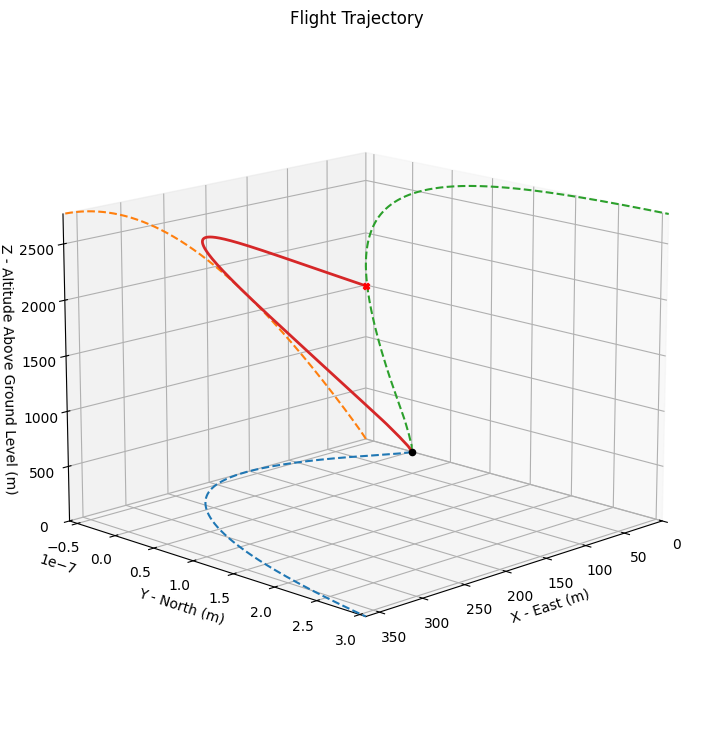

In [30]:
print(f"Apogee: {round(flight_airbrakes.apogee,2)} m ASL, {round(flight_airbrakes.apogee - env.elevation,2)} m AGL")
print(f"Apogee: {round(flight_airbrakes.apogee*3.28084,2)} ft ASL, {round((flight_airbrakes.apogee - env.elevation)*3.28084,2)} ft AGL")
flight_airbrakes.info()
flight_airbrakes.plots.trajectory_3d()